# I. Setup

In [1]:
# import
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode
from textblob import TextBlob, Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

In [2]:
# import dataset et preproc
data = pd.read_csv("data/dataset.csv", sep = ",")

# # drop la colonne total_length
# data = data.drop("total_length", axis=1)

# # drop les lignes où certificate_eligible ou grade = na 
# data.dropna(subset=['certificate_eligible', 'grade'], inplace = True) 

# # binarise la variable certificate_eligible
# data['diplome'] = LabelEncoder().fit_transform(data['certificate_eligible'])

# data.head()

In [3]:
def data_preproc(data):
    #garde seulement lignes où certificate_eligible et grade ne sont pas null
    data.dropna(subset=['certificate_eligible', 'grade'], inplace = True)

    # vire colonne inutile total_length
    data = data.drop("total_length", axis=1)

    # encode le label
    data['certificate_eligible'] = LabelEncoder().fit_transform(data['certificate_eligible'])

    #prépare le corpus pour textblob
    data["corpus"]= data["corpus"].str.lower()
    # enlever les accents
    unidec_corpus = []
    for (i, row) in data.iterrows():
        truc = unidecode(row['corpus'])
        # print(f"user: {row['user']} course :{row['course_id']} new_corp:{truc[:25]}")
        unidec_corpus.append(truc)

    data["corpus"] = unidec_corpus

    tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

    polarity = []
    subjectivity = []

    for (i, row) in data.iterrows():
        # if i>10: quit()
        blob = tb(row['corpus'])
        # print(f"user: {row['user']} course :{row['course_id']} sentiment:{blob.sentiment}")
        polarity.append(blob.sentiment[0])
        subjectivity.append(blob.sentiment[1])

    #update le dataset avec les nouvelles valeurs
    data['polarity']=polarity
    data['subjectivity']=subjectivity

    return(data)

In [4]:
data = data_preproc(data)
data.head()

,user,gender,country,level_of_education,course_id,nb_threads,nb_comments,corpus,delai_1er_post,grade,certificate_eligible,polarity,subjectivity
10,-Luca-,NaN,NaN,NaN,course-v1:MinesTelecom+04017+session03,0,1,"bonjour, je m'appelle luca, je suis consultant...",5,0.38,0,0.126667,0.275000
44,0cbr,NaN,NaN,NaN,course-v1:MinesTelecom+04018+session03,0,1,"bonjour,\nj'ai le meme type de pb .\nje n arri...",28,0.80,1,-0.200000,0.300000
46,0cbr,NaN,NaN,NaN,MinesTelecom/04021S02/session02,1,0,beaucoup de temps passe sur le net pour compre...,26,0.35,0,0.043750,0.325000
57,123AZER,NaN,NaN,NaN,CNAM/01002S04/session04,1,0,"bonjour, nicolas 50 ans officier de sapeurs-po...",10,0.77,1,0.174286,0.278571
68,12nono12,NaN,NaN,NaN,MinesTelecom/04017S02/session02,0,1,"en fait dans le simulateur, le servo moteur se...",31,0.98,1,0.015000,0.175000


In [5]:
data.describe(include = object)

,user,gender,country,level_of_education,course_id,corpus
count,5349,869,589,656,5349,5349
unique,4329,2,37,9,15,5348
top,EGo41,m,FR,m,MinesTelecom/04017/session01,idem
freq,14,758,484,286,868,2


In [6]:
data.describe(exclude = object)

,nb_threads,nb_comments,delai_1er_post,grade,certificate_eligible,polarity,subjectivity
count,5349.000000,5349.000000,5349.000000,5349.000000,5349.000000,5349.000000,5349.000000
mean,1.276313,3.496354,15.509441,0.618854,0.618433,0.134574,0.271865
std,1.856361,20.364191,22.865337,0.367677,0.485816,0.152221,0.420495
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-0.600000
25%,0.000000,0.000000,3.000000,0.260000,0.000000,0.044286,0.153571
50%,1.000000,1.000000,9.000000,0.770000,1.000000,0.122692,0.245625
75%,1.000000,2.000000,20.000000,0.950000,1.000000,0.210000,0.330000
max,25.000000,614.000000,931.000000,1.000000,1.000000,1.000000,17.650000


# II. Plots

## 1. Par user/mooc (n= 5349)

In [7]:
data.shape

(5349, 13)

/tmp/ipykernel_27112/1794321463.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr())


<AxesSubplot: >

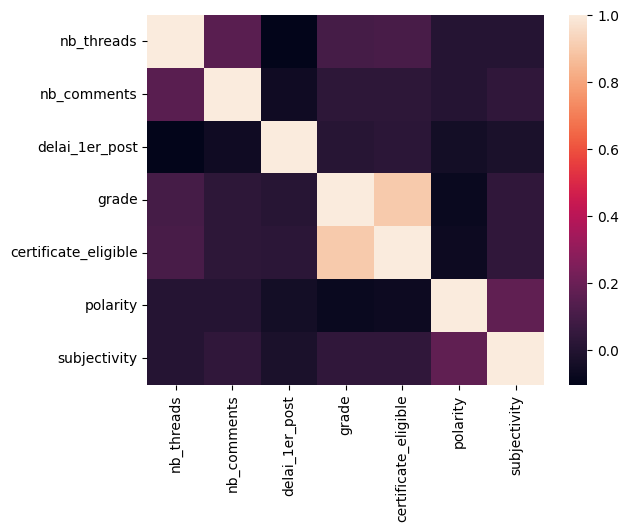

In [8]:
sns.heatmap(data.corr())

In [16]:
## rajouter transfo variables cat en num pour corrmap générale... si possible

plot certif_elig selon var cat

In [17]:
# data_by_certif = data.groupby('certificate_eligible')[['gender','country','level_of_education']].count().reset_index()
# data_by_certif

In [18]:
#plot certif elig selon gender
# fig = px.bar(data_by_certif, 
#              x="gender", 
#              y="certificate_eligible", 
#              title="Nb de messages par user")
# fig.show()


## Par user (n = 4329)

In [10]:
# Création jeu de données avec une seule ligne par user
# count de mooc
data_by_user = data.groupby('user')['course_id'].count().reset_index()

# somme de threads et comments
nb_mess = data.groupby('user')[['nb_threads','nb_comments']].sum().reset_index()

#moyenne de delai de post du premier message
moy_delai = data.groupby('user')['delai_1er_post'].mean().reset_index()

# nb de diplomes
nb_diplome = data.groupby('user')['certificate_eligible'].sum().reset_index()

# rassembler les variables dans le df
data_by_user[['nb_threads','nb_comments']] = nb_mess[['nb_threads','nb_comments']]
data_by_user['moy_delai'] = moy_delai["delai_1er_post"]
data_by_user['nb_diplome'] = nb_diplome["certificate_eligible"]

#calcul de nouvelles variables intermediaires
data_by_user['nb_messages'] = data_by_user["nb_threads"] + data_by_user["nb_comments"]
data_by_user['prop_succes'] = data_by_user["nb_diplome"] / data_by_user["course_id"]
data_by_user = data_by_user.rename(columns = {"course_id" : "nb_mooc"})
# data_by_user

# on devrait pouvoir rajouter les infos de genre, country et level of ed avec une methode de groupby... peut etre unique?
gender = data.groupby('user')["gender"].first().reset_index()
data_by_user['gender'] = gender["gender"]

country = data.groupby('user')["country"].first().reset_index()
data_by_user['country'] = country["country"]

level_of_education = data.groupby('user')["level_of_education"].first().reset_index()
data_by_user['level_of_education'] = level_of_education["level_of_education"]

data_by_user

,user,nb_mooc,nb_threads,nb_comments,moy_delai,nb_diplome,nb_messages,prop_succes,gender,country,level_of_education
0,-Luca-,1,0,1,5.0,0,1,0.0,None,None,None
1,0cbr,2,1,1,27.0,1,2,0.5,None,None,None
2,123AZER,1,1,0,10.0,1,1,1.0,None,None,None
3,12nono12,1,0,1,31.0,1,1,1.0,None,None,None
4,181250,1,1,0,9.0,0,1,0.0,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
4324,zoam14NORA,1,1,0,34.0,0,1,0.0,m,FR,el
4325,zoublos,1,0,2,64.0,1,2,1.0,None,None,None
4326,zraoul,1,0,1,13.0,0,1,0.0,None,None,None
4327,zrash,2,5,3,9.5,1,8,0.5,None,None,None


### Corr heatmap

/tmp/ipykernel_27112/327953006.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data_by_user.corr())


<AxesSubplot: >

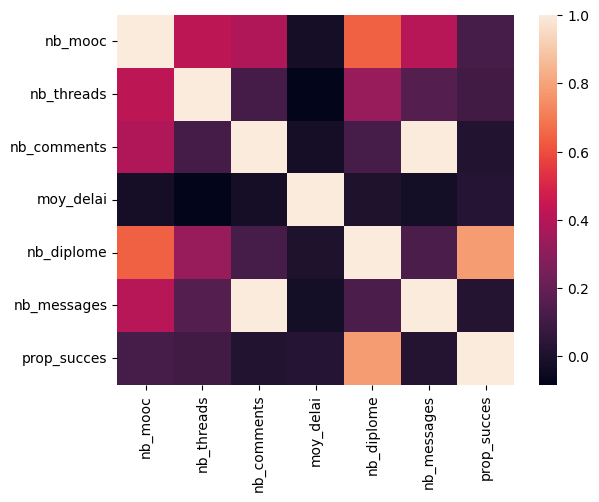

In [11]:
# correlation heatmap
sns.heatmap(data_by_user.corr())

### repartition des genres, country, level_of_ed

In [12]:
# pieplot du nb de genre
fig = px.pie(data_by_user, 
             values='nb_mooc', 
             names='gender', 
             title='Répartition des genres des users')
fig.show()

In [13]:
# pieplot du nb de country
fig = px.pie(data_by_user, 
             values='nb_mooc', 
             names='country', 
             title='Répartition des pays des users')
fig.show()

In [ ]:
# # on drop les null
# # pas forcément utile car on peut déselectionner null sur plotly pour avoir le même résultat
# fig = px.pie(data_by_user.dropna(subset="country"), 
#              values='nb_mooc', 
#              names='country', 
#              title='Répartition des pays des users')
# fig.show()

In [14]:
# pieplot du nb de levels_of_education
fig = px.pie(data_by_user, 
             values='nb_mooc', 
             names='level_of_education', 
             title="Répartition des niveaux d'étude des users")
fig.show()
# se renseigner sur les significations !

### exploration des users pour repérer outliers

In [15]:
# plot nb de mooc par user, mappé par le taux de succès
fig = px.bar(data_by_user.sort_values(by='nb_mooc', ascending = False)[:50], 
             x='user', 
             y='nb_mooc',
             title="Nombre de MOOC par user",
             color='prop_succes')
fig

In [16]:
#  nb messages et threads par user
fig = px.bar(data_by_user.sort_values(by='nb_messages', ascending = False)[:50], 
             x="user", 
             y=["nb_threads", "nb_comments"], 
             title="Nb de messages par user")
fig.show()

In [17]:
# nb_threads par user
fig = px.bar(data_by_user.sort_values(by='nb_threads', ascending = False)[:100], 
             x="user", 
             y="nb_threads", 
             title="Nb de threads par user")
fig.show()

In [18]:
# prop succès en fonction du nb messages
fig = px.scatter(data_by_user, 
             x="nb_messages", 
             y="prop_succes",
             hover_name = "user",
             title="Prop succès selon nb messages")
fig.show()

In [19]:
fig = px.scatter(data_by_user, 
             x="nb_threads", 
             y="prop_succes", 
             hover_name = "user",
             title="Prop succès selon nb threads")
fig.show()

In [20]:
fig = px.scatter(data_by_user, 
             x="nb_comments", 
             y="prop_succes", 
             hover_name = "user",
             title="Prop succès selon nb comments")
fig.show()

Au vu de ces différentes infos, on va retirer seulement EGo41 du dataset car les autres points ne semblent pas être des outliers